In [22]:
import pandas as pd
import torch
from sklearn.datasets import load_diabetes
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import DataLoader

## Exploring and Analyzing Data

In [62]:
df=load_diabetes(as_frame=True,scaled=False)
df['data']

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,59.0,2.0,32.1,101.00,157.0,93.2,38.0,4.00,4.8598,87.0
1,48.0,1.0,21.6,87.00,183.0,103.2,70.0,3.00,3.8918,69.0
2,72.0,2.0,30.5,93.00,156.0,93.6,41.0,4.00,4.6728,85.0
3,24.0,1.0,25.3,84.00,198.0,131.4,40.0,5.00,4.8903,89.0
4,50.0,1.0,23.0,101.00,192.0,125.4,52.0,4.00,4.2905,80.0
...,...,...,...,...,...,...,...,...,...,...
437,60.0,2.0,28.2,112.00,185.0,113.8,42.0,4.00,4.9836,93.0
438,47.0,2.0,24.9,75.00,225.0,166.0,42.0,5.00,4.4427,102.0
439,60.0,2.0,24.9,99.67,162.0,106.6,43.0,3.77,4.1271,95.0
440,36.0,1.0,30.0,95.00,201.0,125.2,42.0,4.79,5.1299,85.0


In [12]:
df['target']

0      151.0
1       75.0
2      141.0
3      206.0
4      135.0
       ...  
437    178.0
438    104.0
439    132.0
440    220.0
441     57.0
Name: target, Length: 442, dtype: float64

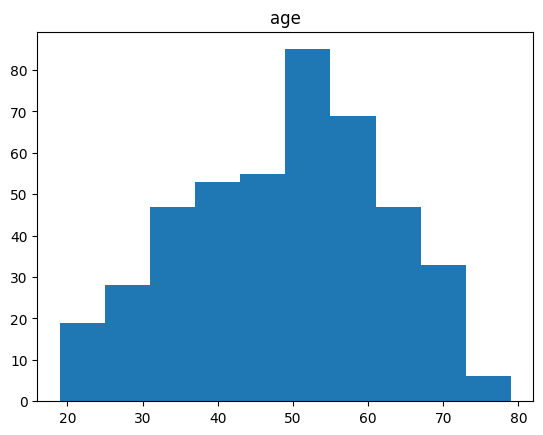

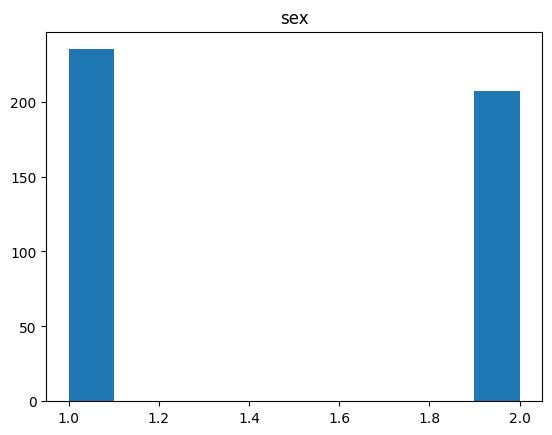

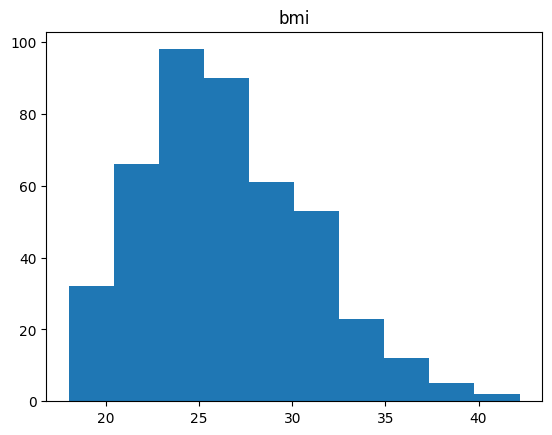

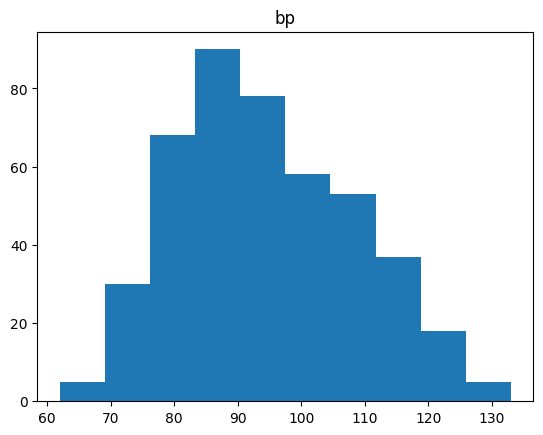

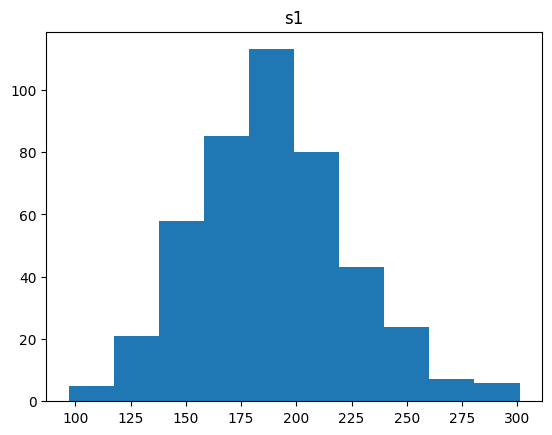

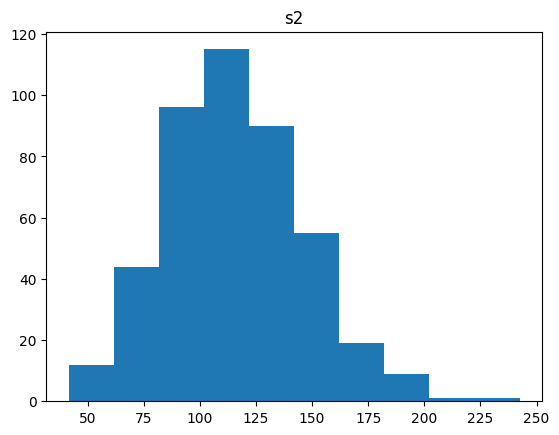

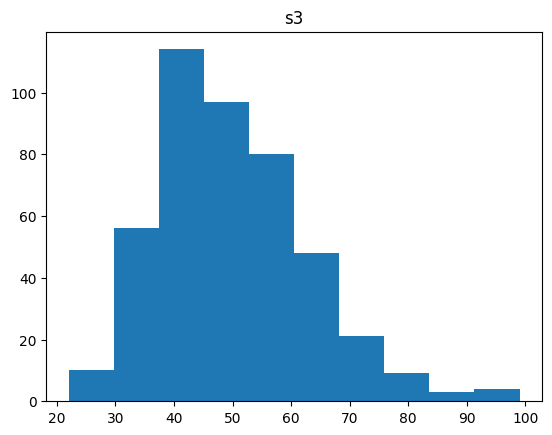

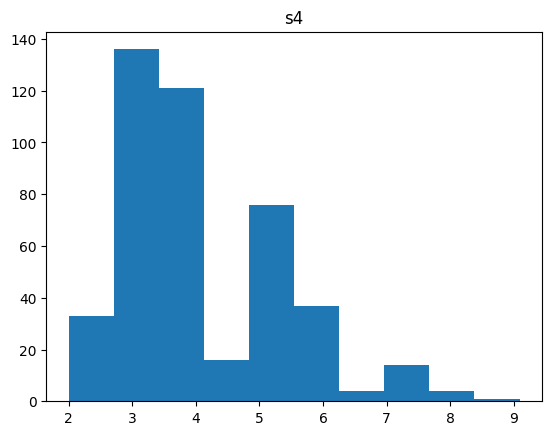

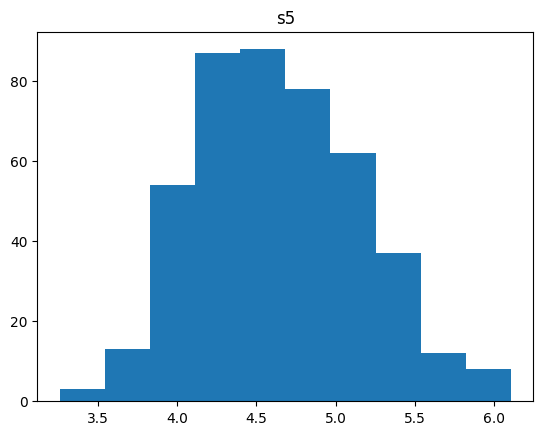

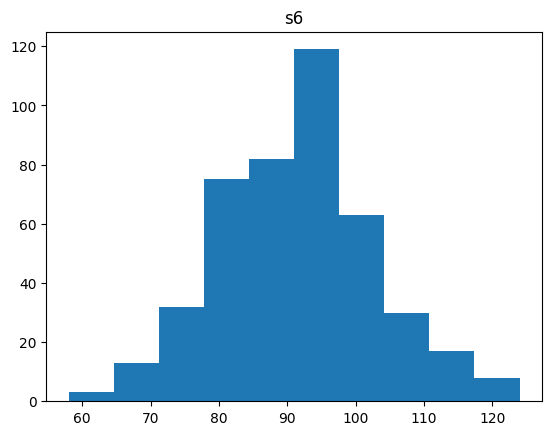

In [63]:
X=df['data']
for i in X.columns:
    plt.figure()
    plt.title(f'{i}')
    plt.hist(X[i])

Here we can see that all my features are actually continous except for sex which is a binary. Maybe for age scaling is necessary to keep the ordering

## Preprocessing Data

In [24]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [64]:
## First split the data
y=df['target']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [65]:
## Convert Sex into 0 and 1
X_train.loc[X_train["sex"] < 2, "sex"] = 0.0
X_train.loc[X_train["sex"] > 0, "sex"] = 1.0
X_test.loc[X_test["sex"] < 2, "sex"] = 0.0
X_test.loc[X_test["sex"] > 0, "sex"] = 1.0

In [66]:
## Standardize columns
X_train_stand = X_train.copy()
X_test_stand = X_test.copy()
for i in X.columns:
    if i=="sex":
        continue
    # fit on training data column
    scale = StandardScaler().fit(X_train_stand[[i]])
    
    # transform the training data column
    X_train_stand[i] = scale.transform(X_train_stand[[i]])
    
    # transform the testing data column
    X_test_stand[i] = scale.transform(X_test_stand[[i]])

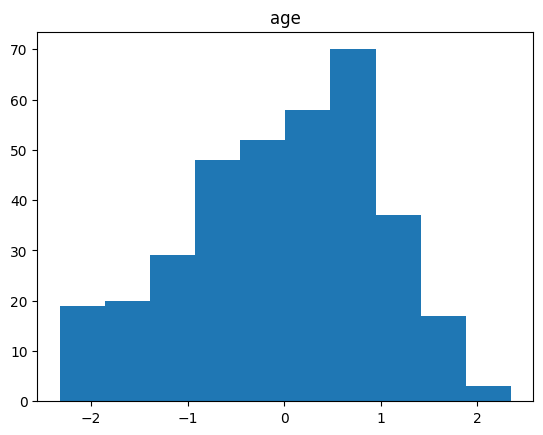

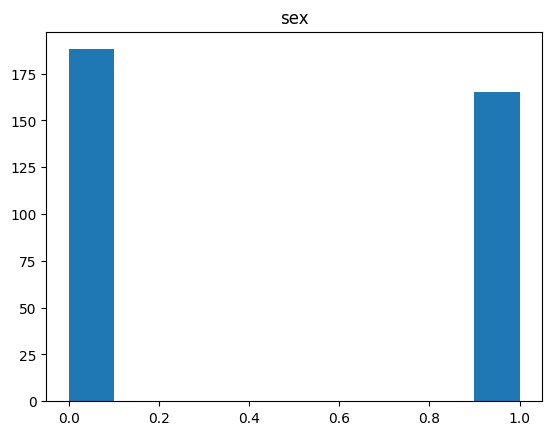

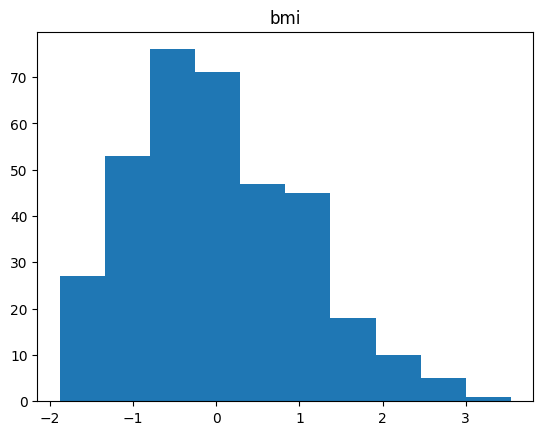

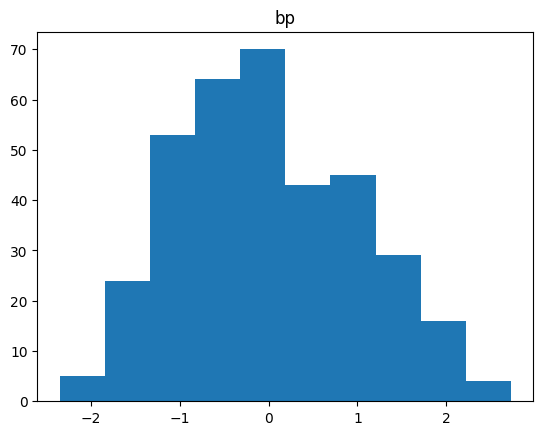

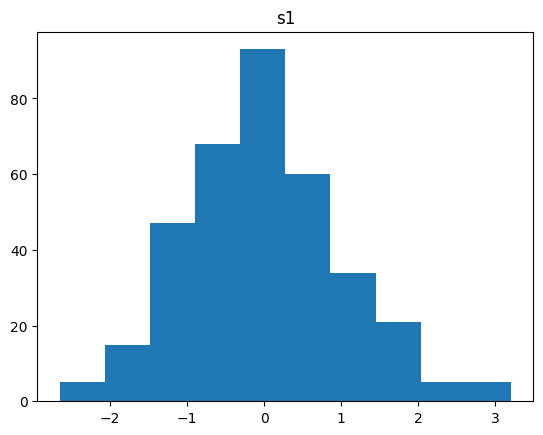

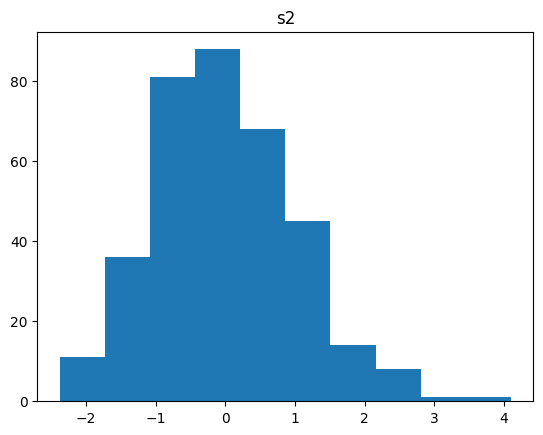

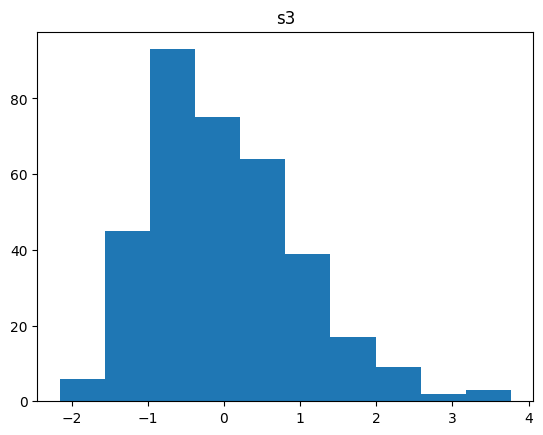

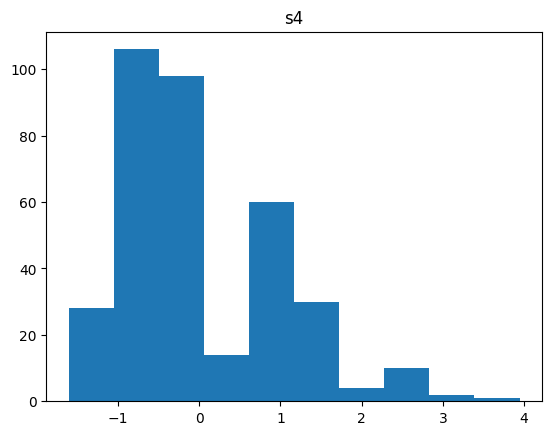

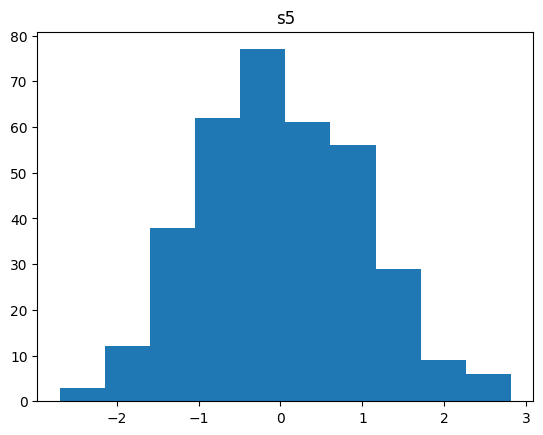

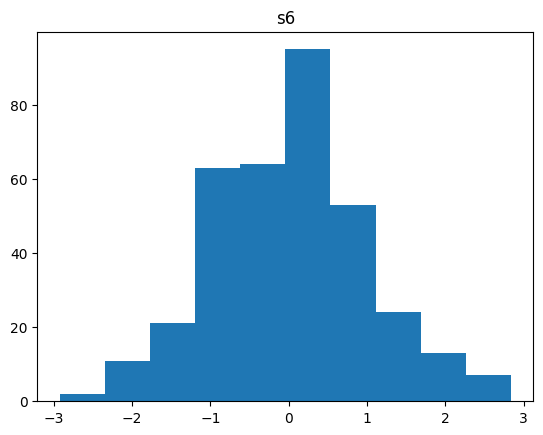

In [24]:
# Replot
for i in X.columns:
    plt.figure()
    plt.title(f'{i}')
    plt.hist(X_train_stand[i])

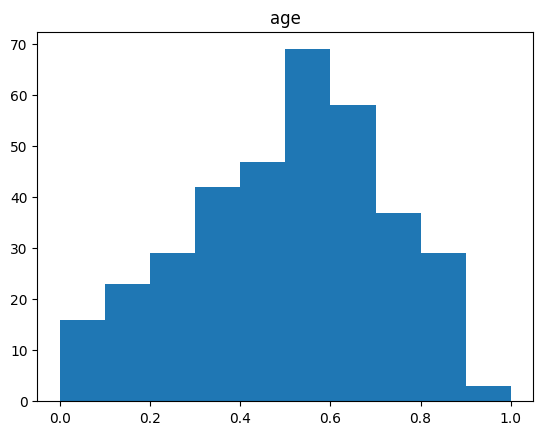

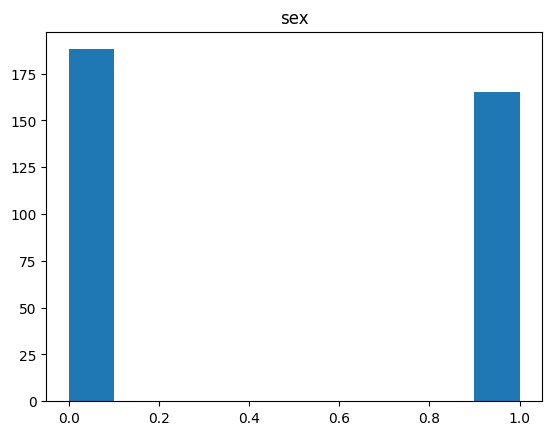

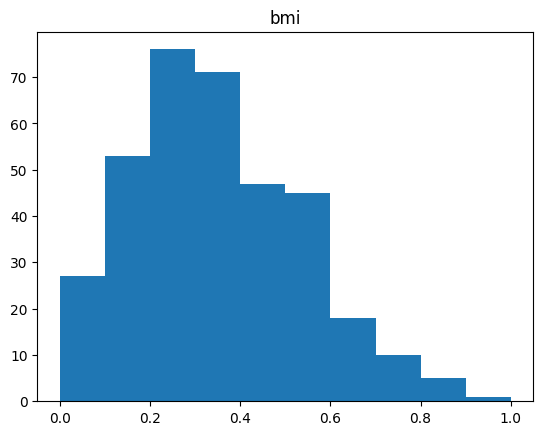

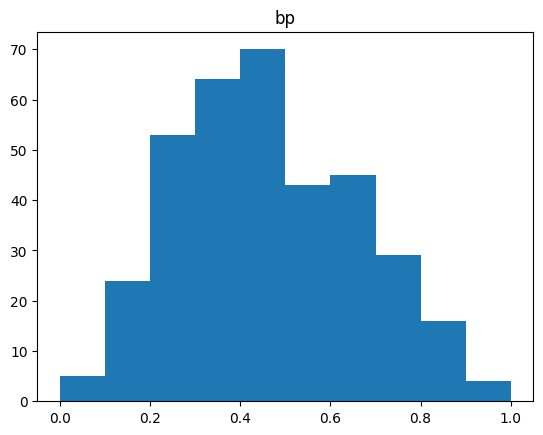

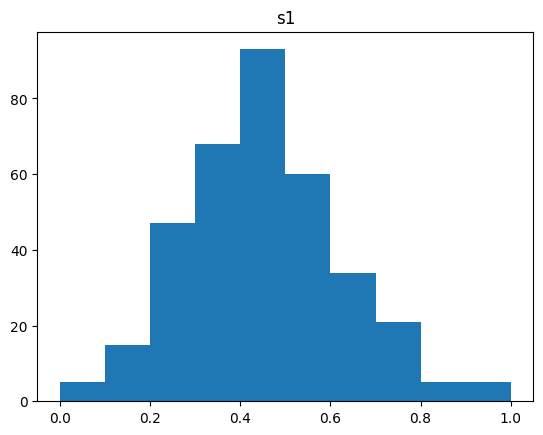

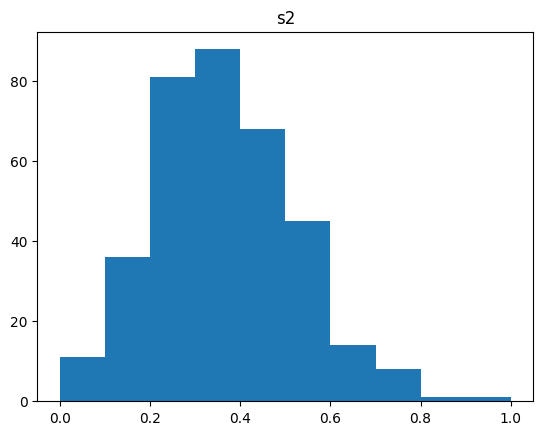

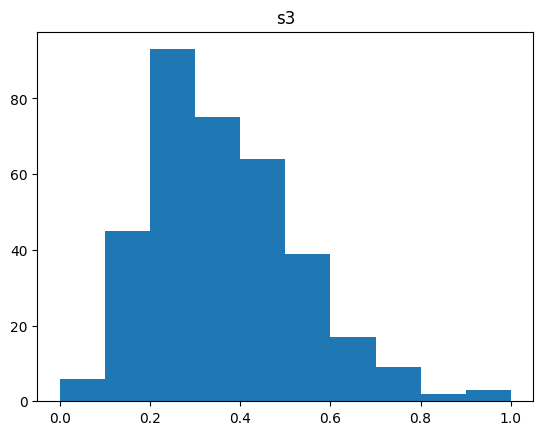

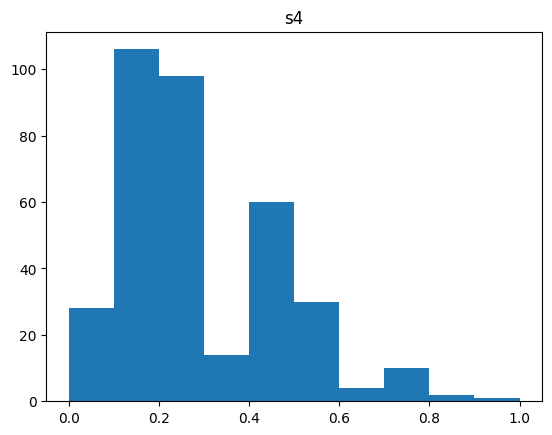

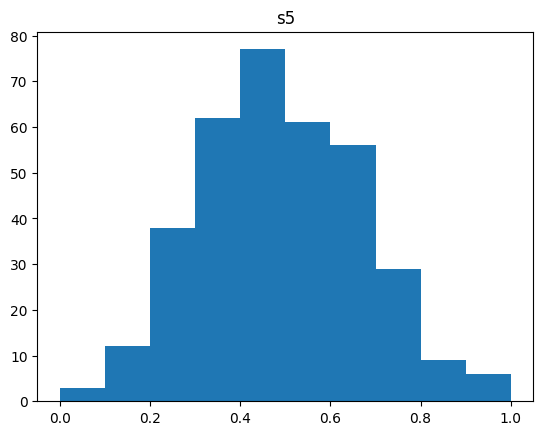

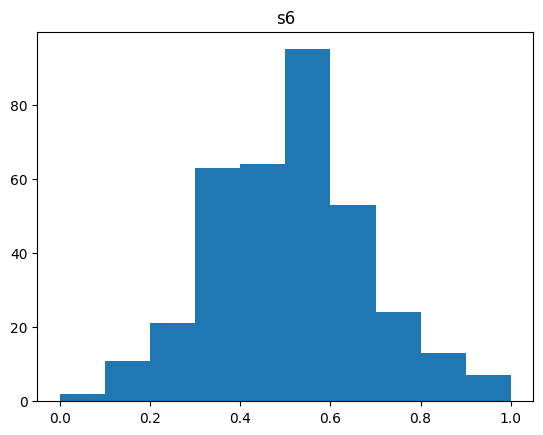

In [28]:
X_train_norm = X_train_stand.copy()
X_test_norm = X_test_stand.copy()
for i in X.columns:
    if i=="sex":
        continue
    # fit on training data column
    norm = MinMaxScaler().fit(X_train_norm[[i]])
    
    # transform the training data column
    X_train_norm[i] = norm.transform(X_train_norm[[i]])
    
    # transform the testing data column
    X_test_norm[i] = norm.transform(X_test_norm[[i]])

for i in X.columns:
    plt.figure()
    plt.title(f'{i}')
    plt.hist(X_train_norm[i])

In [67]:
# Moving on to target
y_train_stand=y_train.copy()
y_test_stand=y_test.copy()
# reshape 1d arrays to 2d arrays
y_train_stand = y_train_stand.values.reshape(len(y_train_stand), 1)
y_test_stand = y_test_stand.values.reshape(len(y_test_stand), 1)
target_scale=StandardScaler().fit(y_train_stand)
y_train_stand=target_scale.transform(y_train_stand)
y_test_stand=target_scale.transform(y_test_stand)

## Dataset and DataLoader

In [68]:
## Custom Dataset
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, df,targets):
        self.df=df.to_numpy()
        self.targets=targets
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample=self.df[idx,:]
        label=self.targets[idx]
        return sample, label

In [69]:
training_data=CustomDataset(df=X_train_stand,targets=y_train_stand)
test_data=CustomDataset(df=X_test_stand,targets=y_test_stand)

## DataLoader
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

## Create Neural Network Model

In [70]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(10, 32),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.Linear(32, 1),
            

        )

    def forward(self, x):
        x = self.linear_relu_stack(x)
        return x

## Training

In [71]:
import torch.optim as optim
model=NeuralNetwork()
# loss function and optimizer
loss_fn = nn.MSELoss()  # mean square error
optimizer = optim.Adam(model.parameters(), lr=0.0001)

def train_one_epoch(model,dataloader, loss_fn, optimiser):
    tot_loss=0
    for i,data in enumerate(dataloader):
        # Calculate loss
        inputs,targets=data
        inputs=inputs.to(torch.float32)
        preds=model(inputs)
        #preds=torch.squeeze(preds)
        targets=targets.to(torch.float32)
        #targets=torch.squeeze(targets)
        loss=loss_fn(preds,targets)
        tot_loss=+loss.item()
        # Backpropagation and update weights
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    tot_loss=tot_loss/i
    return tot_loss


def train(model,train_dl,test_dl, loss_fn, optimiser, epochs):
    for epoch in range(epochs):
        print(f"For EPOCH {epoch}:")
        # Set to training mode
        model.train()
        train_loss=train_one_epoch(model,train_dl, loss_fn, optimiser)

        # Set to eval mode
        model.eval()

        # Disable gradient computation and reduce memory consumption.
        with torch.no_grad():
            running_vloss=0
            for i,vdata in enumerate(test_dl): 
                vinputs, vlabels = vdata
                vinputs=vinputs.to(torch.float32)
                #vinputs=torch.squeeze(vinputs)
                voutputs = model(vinputs)
                #voutputs=torch.squeeze(voutputs)
                vlabels=vlabels.to(torch.float32)
                vloss = loss_fn(voutputs, vlabels)
                running_vloss += vloss
            avg_vloss = running_vloss / (i + 1)

            print(f"Training LOSS:{train_loss}  || Validation LOSS:{avg_vloss}")    

In [72]:
train(model,train_dataloader,test_dataloader, loss_fn, optimizer, 200)

For EPOCH 0:
Training LOSS:0.008604473011060194  || Validation LOSS:1.2004815340042114
For EPOCH 1:
Training LOSS:0.01278415322303772  || Validation LOSS:1.0495911836624146
For EPOCH 2:
Training LOSS:8.271407039666718e-05  || Validation LOSS:0.9317942261695862
For EPOCH 3:
Training LOSS:0.01142675361850045  || Validation LOSS:0.8408098816871643
For EPOCH 4:
Training LOSS:0.000733436339280822  || Validation LOSS:0.7725532054901123
For EPOCH 5:
Training LOSS:0.0016097507693550804  || Validation LOSS:0.7227975130081177
For EPOCH 6:
Training LOSS:0.0032095292752439327  || Validation LOSS:0.6882532835006714
For EPOCH 7:
Training LOSS:7.634142159738325e-05  || Validation LOSS:0.6630367636680603
For EPOCH 8:
Training LOSS:0.0031951777637004852  || Validation LOSS:0.6435838937759399
For EPOCH 9:
Training LOSS:0.0004666350697251883  || Validation LOSS:0.6304024457931519
For EPOCH 10:
Training LOSS:5.571555282751268e-06  || Validation LOSS:0.6229783296585083
For EPOCH 11:
Training LOSS:0.0007573

KeyboardInterrupt: 

In [61]:
#y_test_stand=torch.from_numpy(y_test_stand)
#y_test_stand=y_test_stand.to(torch.float32)
model.eval()
with torch.no_grad():
    preds=model(test)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (89x1 and 10x32)

In [82]:
test=X_test_stand.to_numpy()
test=torch.from_numpy(test)
test=test.to(torch.float32)

In [84]:
model.eval()
with torch.no_grad():
    preds=model(test)

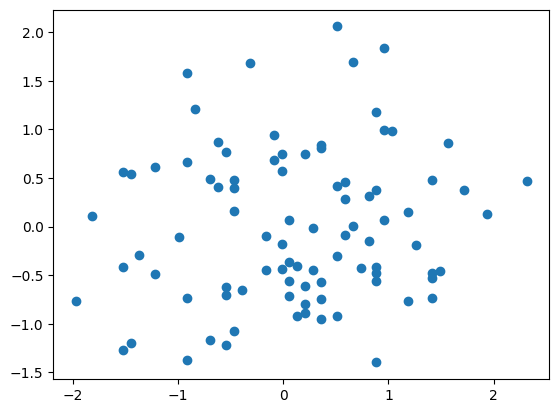

In [93]:
#preds=preds.squeeze().tolist()
plt.scatter(X_test_stand['age'],preds)

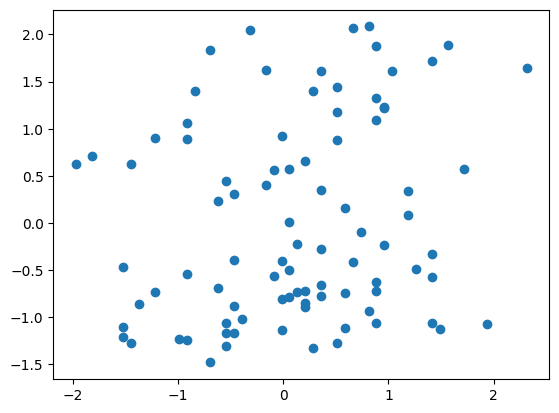

In [95]:
plt.scatter(X_test_stand['age'],y_test_stand)

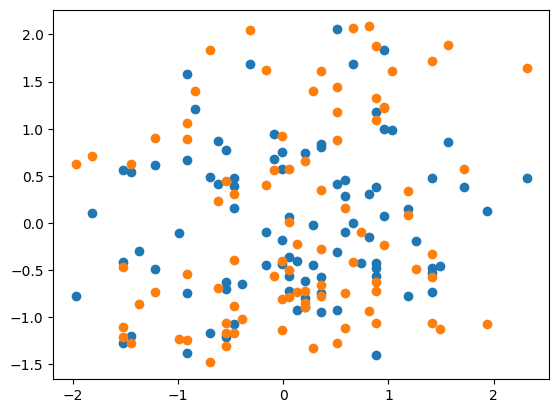

In [96]:
plt.scatter(X_test_stand['age'],preds)
plt.scatter(X_test_stand['age'],y_test_stand)
plt.show()